<a href="https://colab.research.google.com/github/BrotherKim/Colab/blob/main/SEP531/word2vec_skipgram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

코드를 실행하기 전에, GPU를 사용하는 환경으로 바꾸어 주셔야 합니다.

런타임 --> 런타임 유형 변경 --> GPU 로 설정해 주십시오


In [3]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Google Drive 와 연동하는 부분입니다. 

Google Drive에 올려둔 corpus 에 접근할 수 있게 해줍니다.

인증이 필요합니다.



In [4]:
# wiki file 의 경로를 적어주시면 됩니다. 
targetFileNM = "/content/drive/My Drive/Colab Notebooks/kowiki_morpPos_small.txt"

for idx, line in enumerate(open(targetFileNM, encoding='utf-8')):
  print (line)
  if idx == 3 : break



지미/NNP 카터/NNP 제임스/NNP 얼/NNG "/SS 지미/NNP "/SS 카터/NNP 주니어/NNG (/SS ,/SP 1924/SN 년/NNB 10/SN 월/NNB 1/SN 일/NNB ~/SO )/SS 는/JX 민주당/NNG 출신/NNG 미국/NNP 39/SN 번/NNB 째/XSN 대통령/NNG (/SS 1977/SN 년/NNB ~/SO 1981/SN 년/NNB )/SS 이/VCP 다/EF ./SF 지미/NNP 카터/NNP 는/JX 조지아/NNP 주/NNG 섬터/NNP 카운티/NNP 플레/NNP 인스/NNP 마을/NNG 에서/JKB 태어나/VV 았/EP 다/EF ./SF 조지아/NNP 공과대학교/NNG 를/JKO 졸업/NNG 하/XSV 였/EP 다/EF ./SF 그/MM 후/NNG 해군/NNG 에/JKB 들/VV 어/EC 가/VX 아/EC 전함/NNG ·/SP 원자력/NNG ·/SP 잠수함/NNG 의/JKG 승무원/NNG 으로/JKB 일/NNG 하/XSV 였/EP 다/EF ./SF 1953/SN 년/NNB 미국/NNP 해군/NNG 대위/NNG 로/JKB 예편/NNG 하/XSV 였/EP 고/EC 이후/NNG 땅콩/NNG ·/SP 면화/NNG 등/NNB 을/JKO 가꾸/VV 어/EC 많/VA 은/ETM 돈/NNG 을/JKO 벌/VV 었/EP 다/EF ./SF 그/NP 의/JKG 별명/NNG 이/JKS "/SS 땅콩/NNG 농부/NNG "/SS (/SS Peanut/SL Farmer/SL )/SS 로/JKB 알리/VV 어/EC 지/VX 었/EP 다/EF ./SF 1962/SN 년/NNB 조지아/NNP 주/NNG 상원/NNG 의원/NNG 선거/NNG 에서/JKB 낙선/NNG 하/XSV 나/EC 그/MM 선거/NNG 가/JKS 부정선거/NNG 이/VCP 었/EP 음/ETN 을/JKO 입증/NNG 하/XSV 게/EC 되/VV 어/EC 당선/NNG 되/XSA 고/EC ,/SP 1966/SN 년/NNB 조지아/NNP 주/NNG 지사/NNG 선거/NNG 에/JKB 낙선

데이터가 어떻게 생겼는지 보여드리기 위하여 가장 위에 세 라인을 출력하여 보았습니다. 

형태소와 형태소의 품사태그가  "/"로 연결되어 있고, 형태소와 형태소 사이는 공백으로 구분되어 있습니다. 형태소 코드는 세종 형태소 코드 를 참고하시기 바랍니다. 

http://kkma.snu.ac.kr/documents/?doc=postag

In [5]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf
import numpy as np
import codecs, json, glob
import os, datetime, urllib, zipfile, collections

1. 필요한 라이브러리들을 Import 하는 단계입니다. 

    주의깊게 보시지 않으셔도 됩니다. 

In [6]:
learning_rate = 0.001
batch_size = 256
vector_dim = 256
epochs = 10
dictionary_size = 20000
window_size = 3

dictionaryFilePath = os.path.join(os.path.dirname(targetFileNM),
                              "morphemePOS_map.{}.txt".format(
                                  os.path.basename(targetFileNM)))

2. 학습에 필요한 Parameter 들을 정의하였습니다. 

    1) learning_rate: optimizer 가 사용하는 러닝 레이트 입니다

    2) batch_size: 학습 시 모델에 한 번에 feeding 되는 batch의 사이즈 입니다.

    3) vector_dim: embedding 으로 표현하는 vector space 의 차원의 크기 입니다. 차원이 커지면 더 복잡한 표현이 가능하지만, 연산에 소요되는 시간이 길어지고 학습이 잘 일어나지 않을 수 있습니다. 적절한 사이즈를 지정하는 것이 중요합니다. 

    4) epoch: 학습이 반복되는 횟수입니다. 

    5) dictionary_size: embedding 으로 표현 가능한 어휘의 숫자를 지정합니다. 사이즈가 크면 표현할 수 있는 어휘가 많아지지만 쓰임이 낮은 어휘들은 학습이 잘 일어나지 않습니다. 적절한 사이즈를 지정하는 것이 중요합니다. 
    
    6) window_size: skip gram에서 살펴보는 conext words(center word 전후에 있는 word)의 범위입니다. window_size 가 3이라면 center word 의 이전에 나온 word 3 개와 이후에 나온 word 3 개를 살펴보게 됩니다.

In [7]:
'''
사전 생성기
임베딩의 표현력을 결정하는 요소 중의 한 가지인 사전을 생성하는 단계 입니다. 
'''

import collections, os
import codecs, datetime, json

# word 2 vec 의 사전입니다. 이후 입력된 문장은 이 사전을 통해 표현됩니다. 
morpPosDictionary = {}

#사전의 크기에 따른 표현력의 차이를 확인해보기 위하여 크기가 작은 사전과 큰 사전을 함께 생성해보겠습니다
smallDictionarySample = {} 
bigDictionarySample = {} 


def morpPosDictionaryGenerator(morphemeSentenceList):
    morpPosList = []
    for morphemeSentence in morphemeSentenceList:
        for postag in morphemeSentence.replace("+"," ").split(" "):
            postag = postag.strip()

            # 임베딩 (사전) 에 포함시키지 않을 품사들을 설정하였습니다.
            # 저는 어미 / 조사 / 문장부호 를 제거하였습니다. 
            if "/E" in postag: continue
            if "/J" in postag: continue
            if "/S" in postag: continue
            morpPosList.append(postag)

    counted = collections.Counter(morpPosList).most_common()

    #corpus 형태소를 방생빈도가 높은 순서로 정렬하였습니다. 
    #발생 빈도가 높았던 형태소들을 몇 가지 출력해보겠습니다.

    print ("Print Top 5 frequency morpheme/POS")
    for idx, morpFreqPair in enumerate(counted):
      print (morpFreqPair)
      if idx == 5: break

    print ("collections are changed to list and sorted")
    morpPosDictionary["<PAD>"] = len(morpPosDictionary)
    morpPosDictionary["<UNK>"] = len(morpPosDictionary)
    smallDictionarySample["<PAD>"] = len(smallDictionarySample)
    smallDictionarySample["<UNK>"] = len(smallDictionarySample)
    bigDictionarySample["<PAD>"] = len(bigDictionarySample)
    bigDictionarySample["<UNK>"] = len(bigDictionarySample)


    # corpus 에서 발생빈도가 높은 순서로, 지정한 사전의 사이즈만큼 사전을 생성합니다. 
    for i in counted:
        if len(morpPosDictionary) < dictionary_size:
          morpPosDictionary[i[0]] = len(morpPosDictionary)
          
        
        if len(smallDictionarySample) < 5000:
          smallDictionarySample[i[0]] = len(smallDictionarySample)

        if len(bigDictionarySample) < 100000:
          bigDictionarySample[i[0]] = len(bigDictionarySample)

    '''
    #사전을 생성하는 또 하나의 방법입니다. 
    바로 위에 for 문은 특정 dictionary 사이즈를 유지하며 사전을 생성하고, 
    아래 주석처리 된 for 문은 corpus 내에서 특정 발생 빈도 이상인 형태소들을 이용하여 사전을 생성합니다.
    for i in counted:
        if i[1] <= frequencyThreshold:break
        morpPosDictionary[i[0]] = len(morpPosDictionary)
    '''

    #사전이 생성되었습니다. 
    #사전을 일부 print 해보겠습니다. 

    print ("Print top N entry of Dictionary")
    for key in list(morpPosDictionary.keys())[:10]:
      print (key, morpPosDictionary[key])


    #사전을 구글 드라이브에 파일로 덤프합니다. 
    #사전이 어떤 형식으로 생겼는지, 확인해보실 수 있습니다. 
    print ("start print dictionary")
    with codecs.open(dictionaryFilePath,'w',encoding='utf-8') as fw:
        print (json.dumps(morpPosDictionary,ensure_ascii=False),file=fw)
      
    print ("morpPosDict size: ", len(morpPosDictionary))
    print ("small Dictionary size: ", len(smallDictionarySample))
    print ("big Dictionary size: ", len(bigDictionarySample))


import codecs
with codecs.open(targetFileNM, 'r',encoding='utf-8') as fr:
  loadedCorpus = fr.read().upper().strip().split("\n")

morpPosDictionaryGenerator(loadedCorpus)




Print Top 5 frequency morpheme/POS
('하/XSV', 202738)
('이/VCP', 117309)
('년/NNB', 67285)
('되/XSA', 60143)
('들/XSN', 48061)
('하/XSA', 42882)
collections are changed to list and sorted
Print top N entry of Dictionary
<PAD> 0
<UNK> 1
하/XSV 2
이/VCP 3
년/NNB 4
되/XSA 5
들/XSN 6
하/XSA 7
있/VX 8
것/NNB 9
start print dictionary
morpPosDict size:  20000
small Dictionary size:  5000
big Dictionary size:  96711


사전을 생성해 보았습니다. 

상위 빈도 형태소는 하/XSV' (동사파생접미사), '이/VCP' (서술격조사), '년/NNB' (의존명사), '되/XSA' (형용사파생접미사), '들/XSN' (명사파생접미사), '하/XSA' (형용사파생접미사) 로 조사되었습니다. 

사전을 살펴보시면서 이 형태소가 문장을 이해하고 형태소의 의미를 파악하는 것에 도움이 될 지, 혹은 너무나 흔해서 중요한 특징으로 동작하지 않을 지 판단이 필요합니다. 

In [8]:
''' 
Tokenizer 
토크나이저는 입력된 텍스트를 미리 지정한 단위 토큰으로 나누어 주는 모듈입니다. 
단위 토큰으로는 "음절", "어절", "형태소", word-piece 등 다양한 선택지가 있습니다.
이 실습에서는 앞에서 만든 형태소 사전을 이용하여 형태소 단위로 토크나이징 해보겠습니다. 
'''

# 텐서플로우의 케라스 라이브러리에서 지원하는 토크나이저 입니다. 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None, char_level=False,
                                                   oov_token='<UNK>',filters="'",lower=False)
#토크나이저에 앞에서 생성한 사전을 입력해 줍니다. 
tokenizer.word_index = morpPosDictionary
reversed_dictionary = dict(zip(morpPosDictionary.values(), morpPosDictionary.keys()))

tokenizedData_sample = tokenizer.texts_to_sequences(loadedCorpus[:3])

for sample in tokenizedData_sample:
  print (sample)


[10226, 6041, 1903, 1, 1, 10226, 1, 6041, 9514, 1, 1, 1, 4, 1, 10, 1, 17, 1, 1, 1, 809, 487, 42, 1, 45, 83, 85, 1, 1, 4, 1, 1, 4, 1, 3, 1, 1, 10226, 6041, 1, 2272, 61, 1, 2852, 9044, 1, 1246, 1, 406, 1, 1, 1, 2272, 10633, 1, 1173, 2, 1, 1, 1, 24, 51, 1146, 1, 91, 1, 280, 1, 4886, 1, 3734, 1, 4194, 1, 11576, 1, 133, 2, 1, 1, 1, 1, 4, 42, 1146, 6870, 1, 11577, 2, 1, 1, 33, 10634, 1, 4689, 16, 1, 12689, 1, 39, 1, 1080, 1, 3277, 1, 1, 1, 14, 1, 3242, 1, 1, 10634, 2179, 1, 1, 1, 1, 1, 1, 130, 1, 21, 1, 1, 1, 1, 4, 2272, 61, 2727, 551, 307, 1, 5865, 2, 1, 24, 307, 1, 8035, 3, 1, 1, 1, 3290, 2, 1, 12, 1, 1320, 5, 1, 1, 1, 4, 2272, 61, 2728, 307, 1, 5865, 2, 1, 1, 4, 2272, 61, 2728, 1, 2350, 2, 1, 1, 1, 85, 1, 12, 1, 106, 2272, 61, 2727, 551, 1, 70, 45, 7212, 2, 1, 1, 1, 1, 4, 1, 1, 4, 1, 2272, 2728, 1, 2644, 2, 1, 1, 1, 2272, 2200, 1, 589, 1, 1, 42, 1, 167, 1, 1622, 3641, 160, 1, 1877, 1, 1, 1, 1, 4, 85, 307, 1, 809, 473, 1, 2351, 2, 1, 1, 223, 1, 1877, 1, 1, 7494, 1, 3763, 1, 1320, 5, 1, 1, 

토크나이저를 생성하고, 학습 데이터를 토큰으로 표현하여 보았습니다. 

[10226, 6041, 1903, 1, 1, 10226, 1, 6041, 9514, 1, ...]

[654, 654, 1, 1, 1, 1, 1540, 834, 1, 316, 1...]

[654, 1739, 654, 1, 1739, 1, 24, 689, 1, 1137,...]

위에서 프린트 해보았던 지미카터 / 수학 / 상수에 대한 데이터가 숫자의 시퀀스로 표현된 것을 보실 수 있습니다. 1 이라는 숫자가 많이 보이는 것을 볼 수 있는데, 사전에 없는 morpheme 이 데이터에 등장하였다는 의미입니다. 


In [9]:
# word 2 vec 생성을 진행하기에 앞서 사전 크기에 따른 표현력의 차이를 알아보겠습니다. 


# 사전 크기에 따른 표현력 차이를 확인하기 위하여 작은 사전을 이용한 토크나이저와 큰 사전을 이용한 토크나이저도 생성해 보겠습니다. 
small_tk = tf.keras.preprocessing.text.Tokenizer(num_words=None, char_level=False,
                                                   oov_token='<UNK>',filters="'",lower=False)
small_tk.word_index = smallDictionarySample

small_reversed_dictionary = dict(zip(smallDictionarySample.values(), smallDictionarySample.keys()))
small_tokenizedData = small_tk.texts_to_sequences(loadedCorpus[:1])

big_tk = tf.keras.preprocessing.text.Tokenizer(num_words=None, char_level=False,
                                                   oov_token='<UNK>',filters="'",lower=False)
big_tk.word_index = bigDictionarySample
big_reversed_dictionary = dict(zip(bigDictionarySample.values(), bigDictionarySample.keys()))
big_tokenizedData = big_tk.texts_to_sequences(loadedCorpus[:1])

print (len(morpPosDictionary), len(bigDictionarySample))

print ("small dictionary 로 토큰화 한 데이터를 다시 자연어 문장으로 복원하여 보았습니다")
print (" ".join([small_reversed_dictionary[token] for token in small_tokenizedData[0][:30]])+"\n")
print ("기준 dictionary 로 토큰화 한 데이터를 다시 자연어 문장으로 복원하여 보았습니다")
print (" ".join([reversed_dictionary[token] for token in tokenizedData_sample[0][:30]])+"\n")
print ("big dictionary 로 토큰화 한 데이터를 다시 자연어 문장으로 복원하여 보았습니다")
print (" ".join([big_reversed_dictionary[token] for token in big_tokenizedData[0][:30]])+"\n")



20000 96711
small dictionary 로 토큰화 한 데이터를 다시 자연어 문장으로 복원하여 보았습니다
<UNK> <UNK> 제임스/NNP <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> 년/NNB <UNK> 월/NNB <UNK> 일/NNB <UNK> <UNK> <UNK> 민주당/NNG 출신/NNG 미국/NNP <UNK> 번/NNB 째/XSN 대통령/NNG <UNK> <UNK> 년/NNB

기준 dictionary 로 토큰화 한 데이터를 다시 자연어 문장으로 복원하여 보았습니다
지미/NNP 카터/NNP 제임스/NNP <UNK> <UNK> 지미/NNP <UNK> 카터/NNP 주니어/NNG <UNK> <UNK> <UNK> 년/NNB <UNK> 월/NNB <UNK> 일/NNB <UNK> <UNK> <UNK> 민주당/NNG 출신/NNG 미국/NNP <UNK> 번/NNB 째/XSN 대통령/NNG <UNK> <UNK> 년/NNB

big dictionary 로 토큰화 한 데이터를 다시 자연어 문장으로 복원하여 보았습니다
지미/NNP 카터/NNP 제임스/NNP 얼/NNG <UNK> 지미/NNP <UNK> 카터/NNP 주니어/NNG <UNK> <UNK> <UNK> 년/NNB <UNK> 월/NNB <UNK> 일/NNB <UNK> <UNK> <UNK> 민주당/NNG 출신/NNG 미국/NNP <UNK> 번/NNB 째/XSN 대통령/NNG <UNK> <UNK> 년/NNB



큰 사전을 사용하여 토크나이징 한 데이터가 표현력이 더 높은 것을 보실 수 있습니다. (복원하였을 때 원래 내용이 더 많이 남아 있습니다) 

단순히 생각하면 큰 사전을 사용하여 높은 표현력을 가지는 것이 좋다고 생각할 수도 있지만, 데이터 내에서 발생 빈도가 낮은 표현은 학습이 잘 일어나지 않으므로 초기의 랜덤값과 큰 차이 없는 값을 갖게 됩니다. 

적절한 사전의 크기를 결정하는 것은 자연어 데이터를 벡터스페이스에 표현하는데 무척 중요한 작업입니다. 

현재 기본 사전 (크기 20000)에서 가장 빈도가 적은 형태소의 데이터 내 발생 빈도는 12회 입니다. 

In [20]:
sampling_table = sequence.make_sampling_table(dictionary_size)

skipgram_fileNM = os.path.join(os.path.dirname(targetFileNM),"generated_skipgram.txt")

from tensorflow.keras.preprocessing.sequence import skipgrams

def generate_skipgram(tokenSequenceDatum, dictionary_size, window_size):
  
  '''
  # 구현 과제 1 
  토큰의 시퀀스로 표현된 학습 데이터에서 skipgram 을 추출하는 함수를 구현하십시오 
  [10226, 6041, 1903, 1, 1, 10226, 1, 6041, 9514, 1, ...]
  couple 은 특정 두 형태소의 토큰의 pair 를 의미하고 
  labels는 두 형태소가 함께 등장한 적이 있는지를 의미합니다 ( 0: 없음, 1 있음)
  사전에서 임의의 형태소 페어로 negative sample 을 만들어 주어야 합니다. 

  couple 과 labels의 포맷은 다음과 같습니다. 

  couple: [[1664, 1], [5143, 3825], [13522, 6727], [6859, 11804], [7778, 1], [8630, 10689], [7647, 1], [16685, 12264], [6737, 15688], [166, 19234]]
  labels: [1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
  '''

  skip_grams = skipgrams(tokenSequenceDatum, vocabulary_size=dictionary_size, window_size=window_size, sampling_table=sampling_table, negative_samples=0.75)
  
  couple, labels = skip_grams[0], skip_grams[1]
  #print(couple)
  #print(labels)

  return couple, labels


with codecs.open(skipgram_fileNM,'w',encoding='utf-8') as fw:
  for document in loadedCorpus:
    tokenSequenceDatum = tokenizer.texts_to_sequences([document])[0]
            
    couple, labels = generate_skipgram(tokenSequenceDatum, 
                               dictionary_size, window_size=window_size)

    for idx, _ in enumerate(labels):
        #print ("{}\t{}\t{}".format(couple[idx][0], couple[idx][1], labels[idx]))
        print ("{}\t{}\t{}".format(couple[idx][0], couple[idx][1], labels[idx]),file=fw)
  


Skip gram 

기준이 되는 center word 주변에 어떤 표현들이 등장했는지 확인하는 것

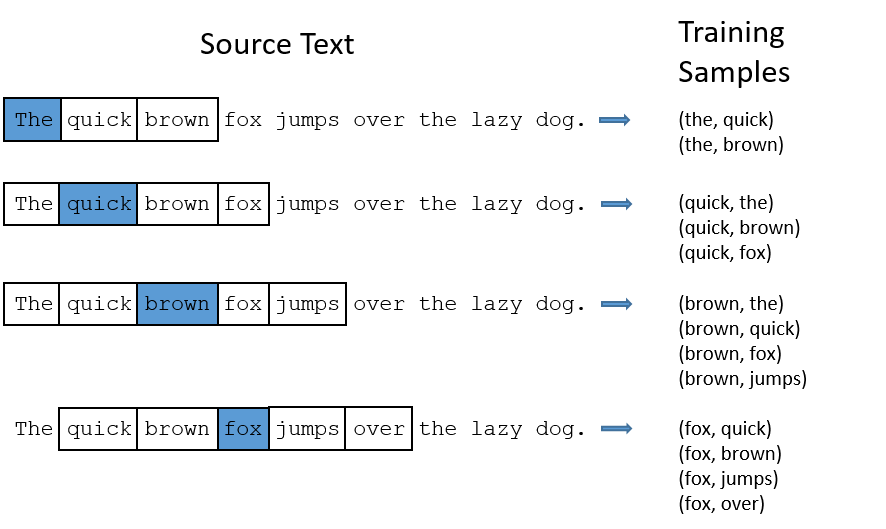

조사 과제 1 

skipgram 생성 과정에서 negative sampling 이라는 것을 하였는데, 목적과 방법에 대해 아래 논문에서 찾아 간단하게 정리 

논문 링크: https://arxiv.org/pdf/1310.4546.pdf


이 텍스트 박스의 아래 영역을 활용하여 정리 및 제출 

--------------------------------- 조사 내용 입력란 ---------------------------------

Negative sampling

목적
skip-gram task 수행 시, backpropagation 과정 중 softmax를 취해야하는 파라미터의 업데이트를 위해 전체 단어의 빈도를 합한 값이 필요하다. 이때, 매번 전체 단어 빈도의 합을 구해야하는 연산량을 sampling 기법으로 낮춰 효율을 높이는 것이 Negative sampling의 목적이다.

방법
전체 corpus 중 문장에서 나타나는 빈도가 높은 단어를 우선적으로 가중치를 줘 골라낸다. 이렇게 추출된 단어들에 대해서만 parameter를 업데이트한다.




------------------------------------------------------------------

In [11]:
## 학습에 필요한 함수를 정의하는 부분입니다. 
## 이 블럭은 주의깊게 보지 않으셔도 됩니다. 

trainTargets = []
numpyData = None
data = []
trainingDataSize = None
trainingData = None


# dataset method
DEBUG = False
# method of loading dataset
tempdir = "split_files" #temporary directory for multiprocessing
split_num = 0
from_memory = False
use_tfrecord = False


def getDictInfo():
    global trainingDataSize
    global trainTargets
    global numpyData
    global split_num



    vocab_size = len(morpPosDictionary)

    trainingDataSize = 0
    for _ in open(skipgram_fileNM, encoding='utf-8'):
      trainingDataSize +=1
    # wc = os.popen("wc -l %s" % skipgram_fileNM)
    # trainingDataSize= int(wc.read().strip().split()[0])
    print (skipgram_fileNM)
    print (trainingDataSize)

    tffile = skipgram_fileNM + '.tfrecord'
    if use_tfrecord:
        # already exists
        if os.path.exists(tffile):
            print ("Data is ready")
            trainTargets = [tffile]
            return

    if use_tfrecord:
        # convert every feature to exam with multi processing
        split_num = 4096

    if split_num:
        assert tempdir.strip('./')
        os.system('rm -rf ' + tempdir)
        os.system('mkdir ' + tempdir)
    
        lines_per_file = int(trainingDataSize / split_num) + 1
        os.system('split -l %d %s %s/sptemp' % (lines_per_file, skipgram_fileNM, tempdir))
        trainTargets = glob.glob('%s/*' % tempdir)
    else:
        trainTargets = [skipgram_fileNM]


    if use_tfrecord:
        import time
        print("start tfrecord build")
        tmpfile = tffile + '.tmp'
        writer = tf.io.TFRecordWriter(tmpfile)
        start = time.time()
        all_len = trainingDataSize
        count = [0, 0]

        def print_status():
            e = time.time() - start
            speed = count[0] / e
            print("...%.2f %% (%d/%d), %.2f proc/sec, %s elapsed" 
                  % (100.0 * count[0]/all_len, count[0], all_len, speed, timeconv(e)))
        
        def write_exam(datas):
            for exam in datas:
                if count[0] % 1000000 == 0:
                    print_status()
                writer.write(exam)
                count[0] += 1
            count[1] += 1
            print_status()

        with mp.Pool(32) as pool:
            ret = []
            for x in trainTargets:
                pool.apply_async(loadexam, args=(x,), callback=write_exam)
            pool.close()
            pool.join()
        
        print("running count:%d, expected:%d" % (count[1], len(trainTargets)))
        assert count[1] == len(trainTargets)
        print_status()

        writer.close()
        os.system('mv %s %s' % (tmpfile, tffile))
        trainTargets = [tffile]
         
    elif from_memory:
        if len(trainTargets) == 1: 
            numpyData = loadnp(trainTargets[0])
        else:
            poolsize = len(trainTargets)
            with mp.Pool(32) as pool:
                numpyData = pool.map(loadnp, trainTargets)
            print("numpy data chunk size :", len(numpyData))
            numpyData = np.concatenate(numpyData)

          
    print ("Data is ready")

def getSkipgramDataset():
    def _py_parse_line(line):
        targetWord, contextWord, label = line.decode('utf-8').strip().split("\t")
        targetWord = np.int(targetWord)
        contextWord = np.int(contextWord)
        label = np.int(label)

        return [targetWord], [contextWord], [label]

    def _decode_tsv(line):
        type_list = [tf.int32, tf.int32, tf.int32]
        data_list = tf.py_func(_py_parse_line, [line], type_list)

        label = data_list[2]
        targetWord = data_list[0]
        contextWord = data_list[1]

        label.set_shape((1,))
        targetWord.set_shape((1,))
        contextWord.set_shape((1,))
        features = {"targetWord": targetWord,
                    "contextWord": contextWord}
        datum = features, label
        return datum

    def _decode_csv(*datas):
        if DEBUG: 
            print("debug:", datas)
            print('-'*10)
        datas2 = [tf.cast(x, tf.int32) for x in datas]
        datas = datas2
        features = {"targetWord" : tf.reshape(datas[0], (-1, 1)),
                    "contextWord" : tf.reshape(datas[1], (-1, 1))}
        label = tf.reshape(datas[2], (-1, 1))
        if DEBUG:
            print("Feature:", features, label)
            print('-'*10)
        return features, label

    def _decode_record_fn(record):
        feature_map = {'targetWord': tf.io.FixedLenFeature([1], tf.int64),
                       'contextWord' : tf.io.FixedLenFeature([1], tf.int64),
                       'label' : tf.io.FixedLenFeature([1], tf.int64)}
        example = tf.io.parse_example(record, feature_map)
        data = {}
        data['targetWord'] = tf.cast(example['targetWord'], tf.int32)
        data['contextWord'] = tf.cast(example['contextWord'], tf.int32)
        label = tf.cast(example['label'], tf.int32)
        return data, label
    
    def getDataset(x):
        if use_tfrecord:
            dataset =  tf.data.TFRecordDataset(trainTargets)
            return dataset
        else:
            return tf.compat.v1.data.experimental.CsvDataset(trainTargets, 
                 buffer_size=1024*1024*128, 
                 record_defaults=[tf.int32, tf.int32, tf.int32],
                 field_delim='\t')
        
    if from_memory:
        # use generator, also slow.
        dataset = tf.data.Dataset.from_generator(generator, 
            ({'targetWord': tf.int32, 'contextWord': tf.int32}, tf.int32),
            output_shapes = ({'targetWord': tf.TensorShape([batch_size, 1]),
                              'contextWord': tf.TensorShape([batch_size, 1])},
                             tf.TensorShape([batch_size, 1])))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(tf.constant(trainTargets))
        dataset = dataset.shuffle(buffer_size=len(trainTargets))
        bulk_length = len(trainTargets)
        dataset = dataset.interleave(lambda filename: getDataset(filename), 
                                 cycle_length=min(16, bulk_length), block_length=bulk_length)
        dataset = dataset.shuffle(20480)
        dataset = dataset.batch(batch_size)
        
        if use_tfrecord:
            dataset = dataset.map(_decode_record_fn, num_parallel_calls=24)
        else:
            dataset = dataset.map(_decode_csv, num_parallel_calls=24)

    if not from_memory:
        dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat()

    return dataset

class SimilarityCallback(tf.keras.callbacks.Callback):
    valid_size = 16    # Random set of words to evaluate similarity on.
    valid_window = 16  # Only pick dev samples in the head of the distribution.
    valid_examples = np.array([35,42,75,85,87,144,181,183,105,107,223,273,272,279,374,376])#np.random.choice(valid_window, valid_size, replace=False)
    #valid_examples = np.random.choice(valid_window, valid_size, replace=False)
    reverse_dictionary = None
    validation_model = None

    def __init__(self, reverse_dictionary, validation_model):
        self.reverse_dictionary = reverse_dictionary
        self.validation_model = validation_model
        self.valid_examples.sort()


    def on_epoch_end(self, epoch, logs=None):
        self.run_sim()

    def run_sim(self):
        print('')
        for i in range(self.valid_size):
            valid_word = self.reverse_dictionary[self.valid_examples[i]]
            top_k = 8  # number of nearest neighbors
            sim = self._get_sim(self.valid_examples[i], len(self.reverse_dictionary), self.validation_model)
            nearest = (-sim).argsort()[1:top_k + 1]
            log_str = 'Nearest to %s:' % valid_word
            for k in range(top_k):
                close_word = self.reverse_dictionary[nearest[k]]
                log_str = '%s %s,' % (log_str, close_word)
            print(log_str)

    @staticmethod
    def _get_sim(valid_word_idx, vocab_size, validation_model):
        in_arr1 = np.full((vocab_size,), valid_word_idx)
        in_arr2 = np.array(range(vocab_size))
        sim = validation_model.predict_on_batch([in_arr1, in_arr2])
        return sim.reshape((vocab_size,))




In [35]:

## word2vec 모델을 생성하는 함수입니다.
## 구현 과제 2번이 포함되어 있습니다. 

from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, merge
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence

def getModels():

    # 입력 레이어를 선언합니다. 
    # input_target:  center 형태소에 대한 입력 레이어입니다
    input_target = Input(shape=(1,), name='targetWord')
    # input_context:  context 형태소에 대한 입력 레이어입니다
    input_context = Input(shape=(1,), name='contextWord')

    #embedding 레이어를 선언합니다. 
    #Keras의 Embedding 레이어를 쓰시는 것을 추천하지만 다른 라이브러리를 사용하셔도 됩니다 
    embedding = Embedding(dictionary_size, vector_dim, input_length=1, name='embedding')
    
    # center 형태소와 context 형태소가 임베딩 레이어를 통과시킵니다. 출력물은 vector space 위의 vector 로 표현됩니다. 
    embedded_target = embedding(input_target)
    embedded_target = Reshape((vector_dim, 1))(embedded_target)
    embedded_context = embedding(input_context)
    embedded_context = Reshape((vector_dim, 1))(embedded_context)

    # 두 벡터를 dot product 하여 두 벡터간의 유사도를  측정합니다. 
    dot_product = tf.keras.layers.dot([embedded_target, embedded_context], axes=1)

    # 아웃풋 레이어와 연결하기 위하여 flatten 함수를 통과시킵니다 --> 대신 아래에 Dense layer 사용
    #flattened = Flatten()

    # sigmoid 함수를 이용하여 activation 합니다. 
    activated = Dense(1, activation='sigmoid')(dot_product)

    model = tf.keras.Model(inputs=[input_target, input_context], outputs=activated)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate) , 
        loss='binary_crossentropy', metrics=['acc'])


    #검증할 때 사용하는 모델입니다. 
    #케라스를 활용하는 방법으로 참고하십시오 
    similarity = tf.keras.layers.dot([embedded_target, embedded_context], axes=-1, normalize=True)
    similarity = Dense(1, activation='sigmoid')(similarity)
    validation_model = tf.keras.Model(inputs=[input_target, input_context], outputs=similarity)

    return model, validation_model

def trainingEmbedding(dataset):
    global model
    global valid_model
    global trainingDataSize

    #strategy = tf.distribute.OneDeviceStrategy(device="/gpu:%d" % gpus[0]) if len(gpus) == 1 else tf.distribute.MirroredStrategy()
    
    

    #dataset = dataset.batch(BATCH_SIZE)
    print (trainingDataSize, batch_size)
    steps_per_epoch = divmod(trainingDataSize, batch_size)[0] + 1
  
    model, valid_model = getModels()

    # model, valid_model = getModels()
    simCallback = SimilarityCallback(reversed_dictionary, valid_model)
    #simCallback = SimilarityCallback(morpPosDictionary, valid_model)
    
    model.fit(dataset,
            steps_per_epoch=steps_per_epoch,
            callbacks=[simCallback],
            epochs=epochs)
    
  
destFileNM = os.path.join(os.path.dirname(targetFileNM),
                              "generated_weights.txt")
def saveModelWeight():
    import datetime
    global model
    global destFileNM
    embeddingWeights = model.get_layer(name="embedding").get_weights()
    np.savetxt(destFileNM,embeddingWeights[0])

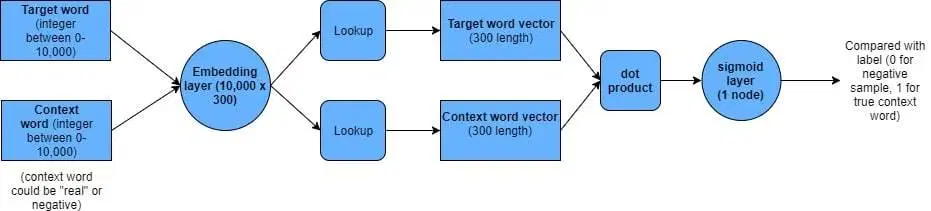

https://teddylee777.github.io/colab/google-colab-%EB%9F%B0%ED%83%80%EC%9E%84-%EC%97%B0%EA%B2%B0%EB%81%8A%EA%B9%80%EB%B0%A9%EC%A7%80

코랩 끊어지지 않게 하기 위한 설정

In [34]:

def main():
  getDictInfo()
  skipgramDataset = getSkipgramDataset()
  if DEBUG:
      for data in skipgramDataset:
          print(data)
          return
  trainingEmbedding(skipgramDataset)
  saveModelWeight()


if __name__ == '__main__':
  main()

/content/drive/My Drive/Colab Notebooks/generated_skipgram.txt
11402074
Data is ready
11402074 256
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
targetWord (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
contextWord (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 256)       5120000     targetWord[0][0]                 
                                                                 contextWord[0][0]                
___________________________________________________________________________________________

In [95]:
function ClickConnect(){
    console.log("코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 1000)

SyntaxError: ignored

grayapple@kaist.ac.kr 김종명 조교 